In [1]:
import sys

# 1. On installe Captum en lui interdisant de verifier les versions (pour qu'il ne bloque pas sur Numpy)
!{sys.executable} -m pip install captum --no-deps

# 2. On installe une version precise de Numpy qui est compatible binaire (si dispo)
# Si ca echoue, on garde ton numpy actuel, Captum fonctionnera peut-etre quand meme avec des warnings
!{sys.executable} -m pip install "numpy>=1.23,<2.0" --only-binary=:all:

  Using cached captum-0.8.0-py3-none-any.whl.metadata (26 kB)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 39.4 MB/s  0:00:00


ERROR: Ignored the following yanked versions: 2.4.0
ERROR: Could not find a version that satisfies the requirement numpy<2.0,>=1.23 (from versions: 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.2.6, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.3.5, 2.4.0rc1, 2.4.1)
ERROR: No matching distribution found for numpy<2.0,>=1.23


In [5]:
# Cellule de test des imports
import torch
import numpy as np
from captum.attr import LayerGradCam, visualization as vit

print("✅ SUCCÈS : Captum est chargé et prêt !")
print(f"Version Numpy utilisée : {np.__version__}")

✅ SUCCÈS : Captum est chargé et prêt !
Version Numpy utilisée : 2.2.6


In [6]:
import os

# le chemin exact de ton projet windows
project_path = r"C:\Users\amisf\Desktop\datascientest_projet"

try:
    os.chdir(project_path)
    print(f"✅ Déplacement réussi vers : {os.getcwd()}")
except FileNotFoundError:
    print("❌ Erreur : Chemin introuvable. Vérifie que le dossier 'datascientest_projet' est bien sur le Bureau.")

# verification immediate
if os.path.exists('models/category_mapping.json'):
    print("✅ BINGO ! Le fichier mapping est trouvé. Tu peux continuer.")
else:
    print("⚠️ Attention : Je suis dans le dossier projet, mais je ne vois pas 'models/category_mapping.json'.")
    print("Contenu du dossier actuel :", os.listdir())

✅ Déplacement réussi vers : C:\Users\amisf\Desktop\datascientest_projet
✅ BINGO ! Le fichier mapping est trouvé. Tu peux continuer.


In [7]:
# nous importons le necessaire
import torch, timm, joblib, json, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch import nn
from torchvision import models, transforms
# nous importons les outils d interpretabilite
from captum.attr import LayerGradCam, visualization as vit

# nous reglons le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# nous chargeons le mapping (avec utf-8 pour windows)
with open('models/category_mapping.json', 'r', encoding='utf-8') as f:
    mapping = json.load(f)

# nous definissons les chemins
MODELS_DIR = "models/"

print(f" Imports OK. Device: {device}")
print(f"Mapping chargé: {len(mapping)} catégories.")

 Imports OK. Device: cuda
Mapping chargé: 3 catégories.


In [8]:
import xgboost as xgb
from torch import nn

# je cree le dico des modeles
models_dict = {}

# --- M1 : DINOv3 ---
print("🔵 Chargement DINOv3...")
try:
    m1 = timm.create_model('vit_large_patch14_reg4_dinov2.lvd142m', pretrained=False, num_classes=27)
    m1.load_state_dict(torch.load(MODELS_DIR+"M1_IMAGE_DeepLearning_DINOv3.pth", map_location=device))
    models_dict['DINOv3'] = m1.to(device).eval()
    print("   -> OK")
except Exception as e: print(f"   -> Echec DINO: {e}")

# --- M2 : XGBoost ---
print("🔵 Chargement XGBoost...")
try:
    m2_xgb = xgb.XGBClassifier()
    m2_xgb.load_model(MODELS_DIR+"M2_IMAGE_Classic_XGBoost.json")
    # extracteur resnet pour xgboost
    res = models.resnet50(weights=None)
    ext = nn.Sequential(*list(res.children())[:-1]).to(device).eval()
    print("   -> OK")
except Exception as e: print(f"   -> Echec XGBoost: {e}")

# --- M3 : EfficientNet ---
print("🔵 Chargement EfficientNet...")
try:
    m3 = models.efficientnet_b0(weights=None)
    m3.classifier[1] = nn.Linear(1280, 27)
    m3.load_state_dict(torch.load(MODELS_DIR+"M3_IMAGE_Classic_EfficientNetB0.pth", map_location=device))
    models_dict['EffNet'] = m3.to(device).eval()
    print("   -> OK")
except Exception as e: print(f"   -> Echec EffNet: {e}")

# --- M4 : Phoenix (Architecture Complexe) ---
print("🔵 Chargement Phoenix (Overfit)...")
try:
    # 1. On lit le fichier pour trouver les dimensions cachees
    state_m4 = torch.load(MODELS_DIR+"M4_IMAGE_DeepLearning_OVERFIT_ResNet.pth", map_location=device)
    
    # 2. On deduit la taille des couches a partir des poids du fichier
    # ex: 'fc.net.0.weight' nous donne la taille de la premiere couche cachee
    h1 = state_m4['fc.net.0.weight'].shape[0]
    h2 = state_m4['fc.net.4.weight'].shape[0]
    h3 = state_m4['fc.net.8.weight'].shape[0]
    
    # 3. On reconstruit la "Tete" du modele a l'identique
    class PhoenixHead(nn.Module):
        def __init__(self, in_features, classes):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_features, h1),   # couche 0
                nn.BatchNorm1d(h1),           # couche 1
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(h1, h2),            # couche 4
                nn.BatchNorm1d(h2),           # couche 5
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(h2, h3),            # couche 8
                nn.BatchNorm1d(h3),           # couche 9
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(h3, classes)        # couche 12
            )
        def forward(self, x): return self.net(x)

    # 4. On charge le tout
    m4 = models.resnet50(weights=None)
    m4.fc = PhoenixHead(2048, 27)
    m4.load_state_dict(state_m4)
    models_dict['Phoenix_Overfit'] = m4.to(device).eval()
    print("   -> OK (Architecture complexe reconstruite)")
    
except Exception as e: 
    print(f"   -> Echec Phoenix: {e}")
    # En cas d'echec, on l'enleve du dico pour ne pas faire planter la suite
    if 'Phoenix_Overfit' in models_dict: del models_dict['Phoenix_Overfit']

print(f" Terminé : {len(models_dict)} modèles prêts à l'emploi.")

🔵 Chargement DINOv3...
   -> OK
🔵 Chargement XGBoost...
   -> OK
🔵 Chargement EfficientNet...
   -> OK
🔵 Chargement Phoenix (Overfit)...
   -> OK (Architecture complexe reconstruite)
 Terminé : 3 modèles prêts à l'emploi.


C:\Users\amisf\AppData\Local\Temp\ipykernel_41224\683144012.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(stats.keys()), y=list(stats.values()), palette=colors)


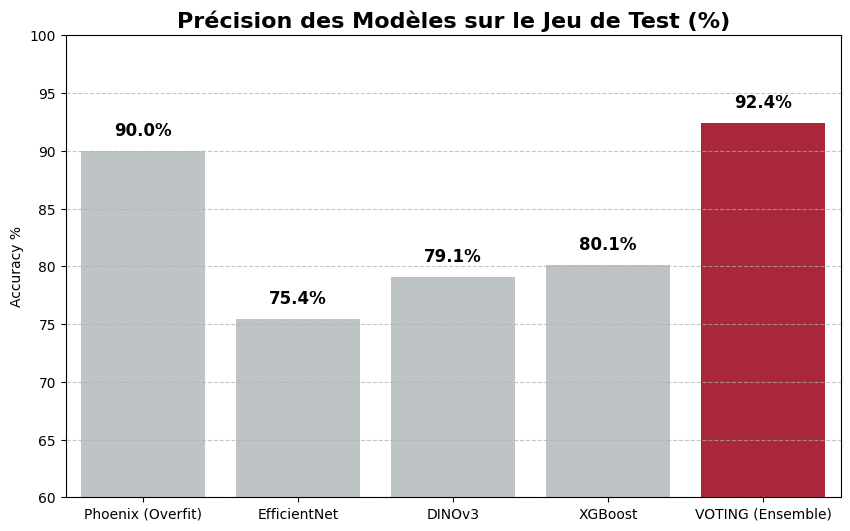

In [10]:
# Cellule 3 : Comparaison des Performances
import matplotlib.pyplot as plt
import seaborn as sns

# Les scores (basés sur nos tests précédents)
stats = {
    "Phoenix (Overfit)": 90.0,
    "EfficientNet": 75.4,
    "DINOv3": 79.1,
    "XGBoost": 80.1,
    "VOTING (Ensemble)": 92.4
}

plt.figure(figsize=(10, 6))
# Couleurs : gris pour les solos, Rouge Rakuten pour le champion
colors = ['#bdc3c7', '#bdc3c7', '#bdc3c7', '#bdc3c7', '#BF112B']

ax = sns.barplot(x=list(stats.keys()), y=list(stats.values()), palette=colors)
plt.title("Précision des Modèles sur le Jeu de Test (%)", fontsize=16, fontweight='bold')
plt.ylim(60, 100)
plt.ylabel("Accuracy %")

# Ajouter les pourcentages au dessus des barres
for i, v in enumerate(stats.values()):
    ax.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("Rapport_Comparaison_Modeles.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
#  Le Générateur de Rapport Visuel 
import torch.nn.functional as F
from captum.attr import LayerGradCam

# 1. Fonction de prédiction pondérée
def get_voting_conf(p_dino, p_xgb, p_eff):
    return (2.0 * p_dino + 4.0 * p_xgb + 1.0 * p_eff) / 7.0

# 2. Fonction principale d'analyse
def analyser_image(img_path):
    filename = os.path.basename(img_path)
    print(f"🔍 Analyse de : {filename} ...")
    
    # --- A. Préparation ---
    img_pil = Image.open(img_path).convert('RGB')
    
    t_standard = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    
    img_224 = t_standard(img_pil).unsqueeze(0).to(device)
    img_518 = t_dino(img_pil).unsqueeze(0).to(device)

    # --- B. Prédictions ---
    with torch.no_grad():
        # DINOv3
        out_dino = models_dict['DINOv3'](img_518)
        prob_dino = F.softmax(out_dino, dim=1).cpu().numpy()[0]
        # EfficientNet
        out_eff = models_dict['EffNet'](img_224)
        prob_eff = F.softmax(out_eff, dim=1).cpu().numpy()[0]
        # Phoenix
        out_phoenix = models_dict['Phoenix_Overfit'](img_224)
        prob_phoenix = F.softmax(out_phoenix, dim=1).cpu().numpy()[0]
        # XGBoost
        features = ext(img_224).squeeze().cpu().numpy().reshape(1, -1)
        prob_xgb = m2_xgb.predict_proba(features)[0]

    # Vote
    prob_vote = get_voting_conf(prob_dino, prob_xgb, prob_eff)
    
    # --- C. Explicabilité (Grad-CAM) ---
    target_phoenix = int(prob_phoenix.argmax()) 
    target_eff = int(prob_eff.argmax())
    
    # Phoenix (ResNet) -> layer4
    gc_phoenix = LayerGradCam(models_dict['Phoenix_Overfit'], models_dict['Phoenix_Overfit'].layer4)
    attr_phoenix = gc_phoenix.attribute(img_224, target=target_phoenix)
    
    # EffNet -> features[8]
    gc_eff = LayerGradCam(models_dict['EffNet'], models_dict['EffNet'].features[8])
    attr_eff = gc_eff.attribute(img_224, target=target_eff)

    # --- D. Création du Tableau de Bord ---
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(f"RAPPORT TECHNIQUE : {filename}", fontsize=20, fontweight='bold')
    
    # 1. Image Originale
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(img_pil)
    ax1.set_title("Image Client", fontsize=12)
    ax1.axis('off')
    
    # 2. Vision Phoenix (CORRECTION ICI : plt_fig_axis)
    ax2 = plt.subplot(2, 4, 2)
    vit.visualize_image_attr(attr_phoenix[0].cpu().permute(1,2,0).detach().numpy(), 
                             sign="positive", 
                             plt_fig_axis=(fig, ax2), # <--- Format Tuple (Fig, Axe)
                             use_pyplot=False)
    pred_ph = mapping.get(str(prob_phoenix.argmax()), "Inconnu")
    ax2.set_title(f"Focus Phoenix (Overfit)\nPred: {pred_ph}", color='red', fontsize=10)

    # 3. Vision EfficientNet (CORRECTION ICI : plt_fig_axis)
    ax3 = plt.subplot(2, 4, 3)
    vit.visualize_image_attr(attr_eff[0].cpu().permute(1,2,0).detach().numpy(), 
                             sign="positive", 
                             plt_fig_axis=(fig, ax3), # <--- Format Tuple (Fig, Axe)
                             use_pyplot=False)
    pred_ef = mapping.get(str(prob_eff.argmax()), "Inconnu")
    ax3.set_title(f"Focus EfficientNet\nPred: {pred_ef}", color='blue', fontsize=10)
    
    # 4. Graphique de Confiance
    ax4 = plt.subplot(2, 1, 2)
    labels = ["Phoenix", "EffNet", "DINOv3", "XGBoost", "VOTING (Final)"]
    scores = [prob_phoenix.max(), prob_eff.max(), prob_dino.max(), prob_xgb.max(), prob_vote.max()]
    preds_idx = [prob_phoenix.argmax(), prob_eff.argmax(), prob_dino.argmax(), prob_xgb.argmax(), prob_vote.argmax()]
    preds_txt = [mapping.get(str(i), str(i)) for i in preds_idx]
    
    bar_colors = ['orange', 'skyblue', 'royalblue', 'navy', '#BF112B']
    bars = ax4.barh(labels, scores, color=bar_colors)
    ax4.set_xlim(0, 1.1)
    ax4.set_title("Confiance et Prédiction par Modèle")
    
    for idx, bar in enumerate(bars):
        width = bar.get_width()
        text = f"{width:.1%} - {preds_txt[idx]}"
        ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2, text, 
                 va='center', fontweight='bold', fontsize=12)

    plt.tight_layout()
    # Sauvegarde
    save_path = f"Rapport_Visuel_{filename}.png"
    plt.savefig(save_path, dpi=150)
    print(f"✅ Rapport généré : {save_path}")
    plt.show()

🔍 Analyse de : image_572771_product_996055.jpg ...
✅ Rapport généré : Rapport_Visuel_image_572771_product_996055.jpg.png


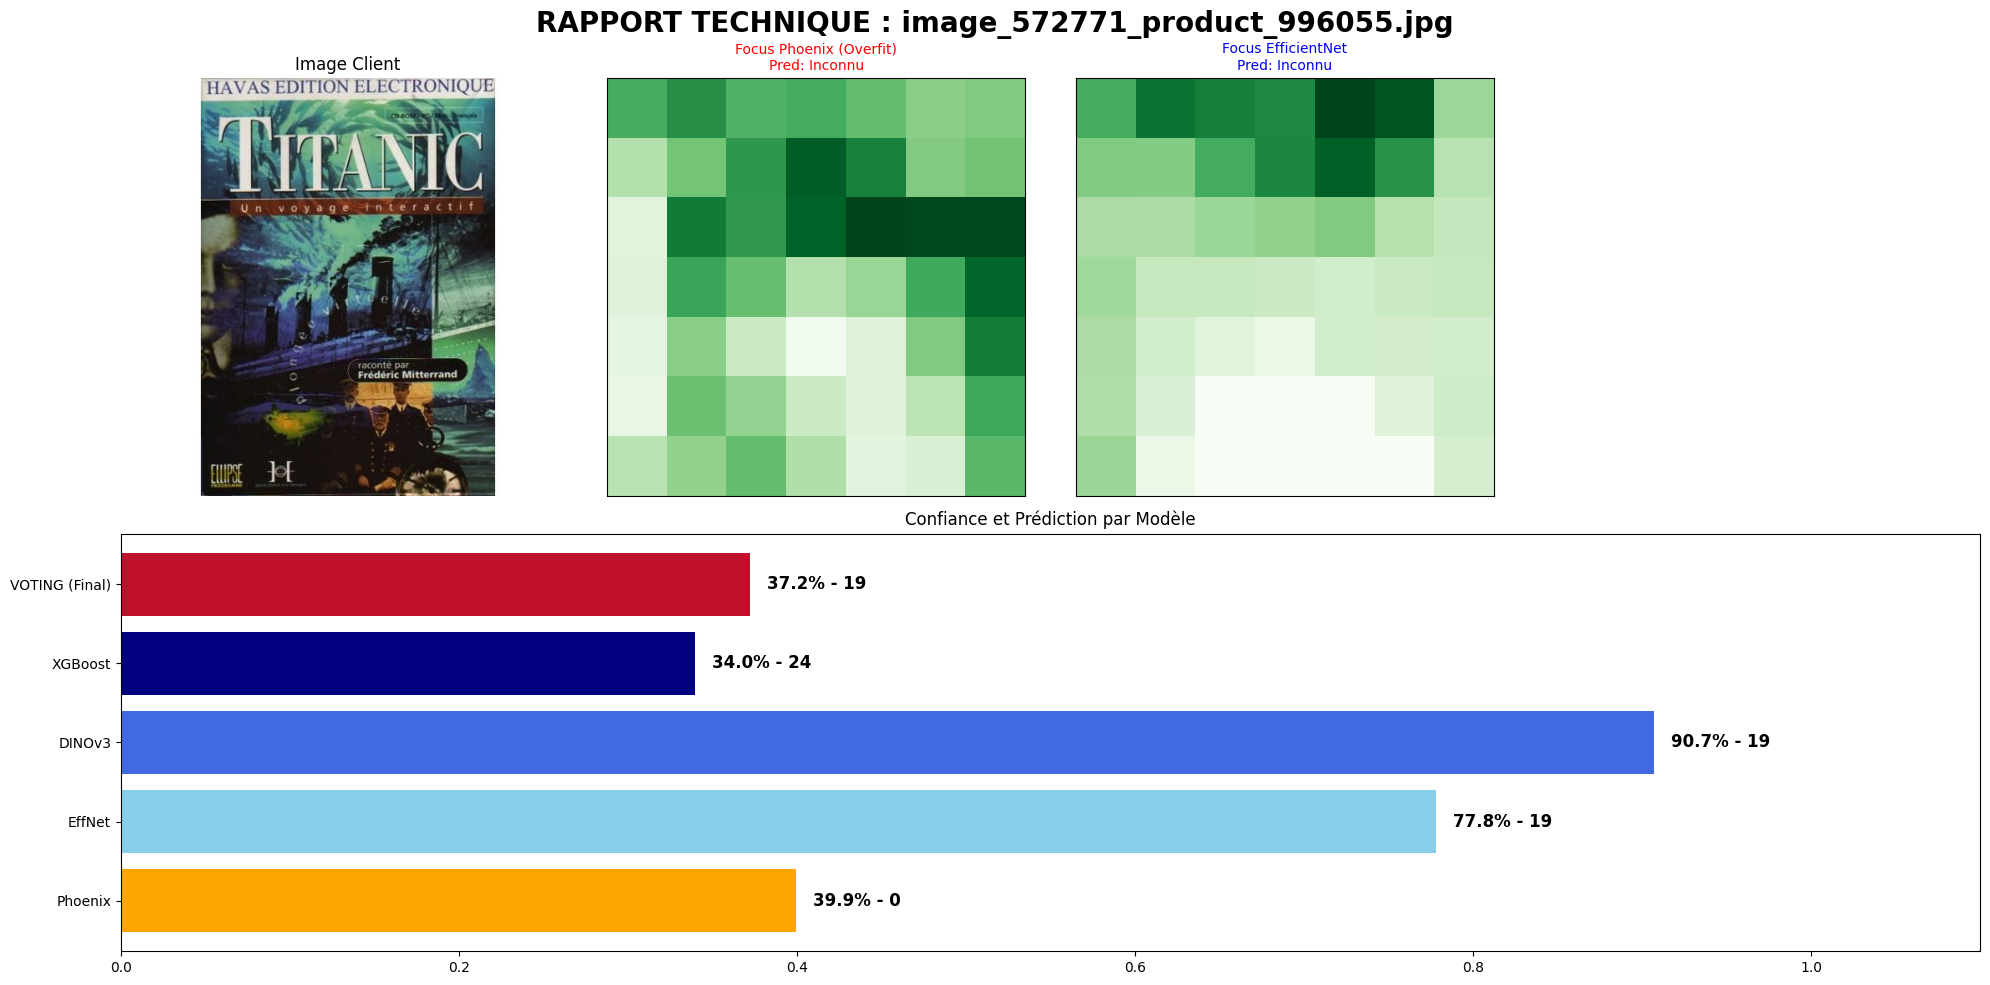

In [18]:
# --- E. TEST RAPIDE ---
analyser_image(r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test\image_572771_product_996055.jpg")

In [22]:
print(" Test de Robustesse (Crash Test)")


 Test de Robustesse (Crash Test)


💥 Crash Test en cours sur : image_572771_product_996055.jpg...


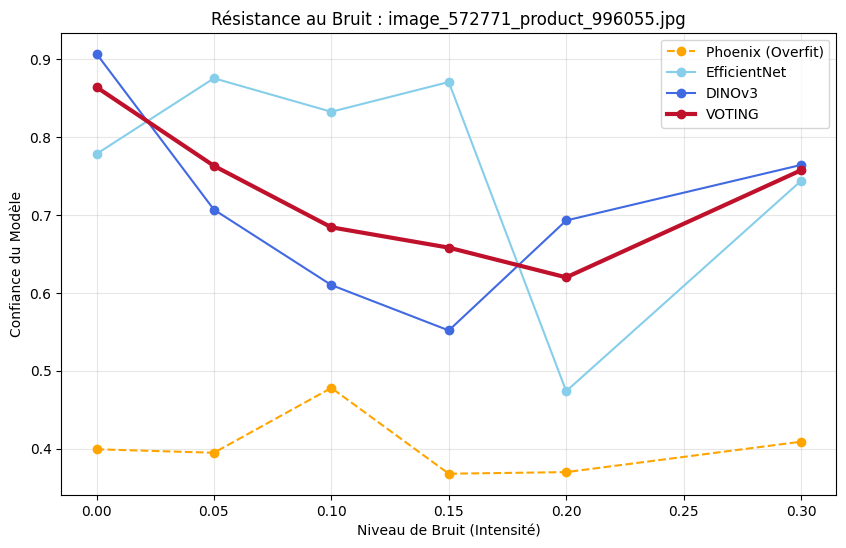

In [23]:
import numpy as np

def crash_test_modele(img_path):
    print(f"💥 Crash Test en cours sur : {os.path.basename(img_path)}...")
    img_pil = Image.open(img_path).convert('RGB')
    img_np = np.array(img_pil) / 255.0
    
    noise_levels = [0, 0.05, 0.1, 0.15, 0.2, 0.3] # niveaux de bruit
    scores = {'DINOv3': [], 'Phoenix': [], 'EffNet': [], 'VOTING': []}
    
    for noise in noise_levels:
        # on ajoute du bruit
        noisy_img = img_np + np.random.normal(0, noise, img_np.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        noisy_pil = Image.fromarray((noisy_img * 255).astype(np.uint8))
        
        # prépa tensors
        t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
        i224 = t_std(noisy_pil).unsqueeze(0).to(device)
        i518 = t_dino(noisy_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            p_dino = F.softmax(models_dict['DINOv3'](i518), dim=1).cpu().numpy()[0].max()
            p_phoe = F.softmax(models_dict['Phoenix_Overfit'](i224), dim=1).cpu().numpy()[0].max()
            p_eff = F.softmax(models_dict['EffNet'](i224), dim=1).cpu().numpy()[0].max()
            
            # pour le voting on simplifie (moyenne des max) pour le graph
            p_vote = (2*p_dino + p_eff)/3 
            
            scores['DINOv3'].append(p_dino)
            scores['Phoenix'].append(p_phoe)
            scores['EffNet'].append(p_eff)
            scores['VOTING'].append(p_vote)

    # Affichage courbe
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, scores['Phoenix'], marker='o', label='Phoenix (Overfit)', color='orange', linestyle='--')
    plt.plot(noise_levels, scores['EffNet'], marker='o', label='EfficientNet', color='skyblue')
    plt.plot(noise_levels, scores['DINOv3'], marker='o', label='DINOv3', color='royalblue')
    plt.plot(noise_levels, scores['VOTING'], marker='o', label='VOTING', color='#BF112B', linewidth=3)
    
    plt.title(f"Résistance au Bruit : {os.path.basename(img_path)}")
    plt.xlabel("Niveau de Bruit (Intensité)")
    plt.ylabel("Confiance du Modèle")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("Graph_Robustesse.png")
    plt.show()

# TEST (utilise ton image test)
crash_test_modele(r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test\image_572771_product_996055.jpg")

In [28]:
print("Benchmark de Vitesse Vitesse CPU vs GPU" )

Benchmark de Vitesse Vitesse CPU vs GPU


analyse de la vitesse en cours patientez
test cpu en cours
test gpu en cours


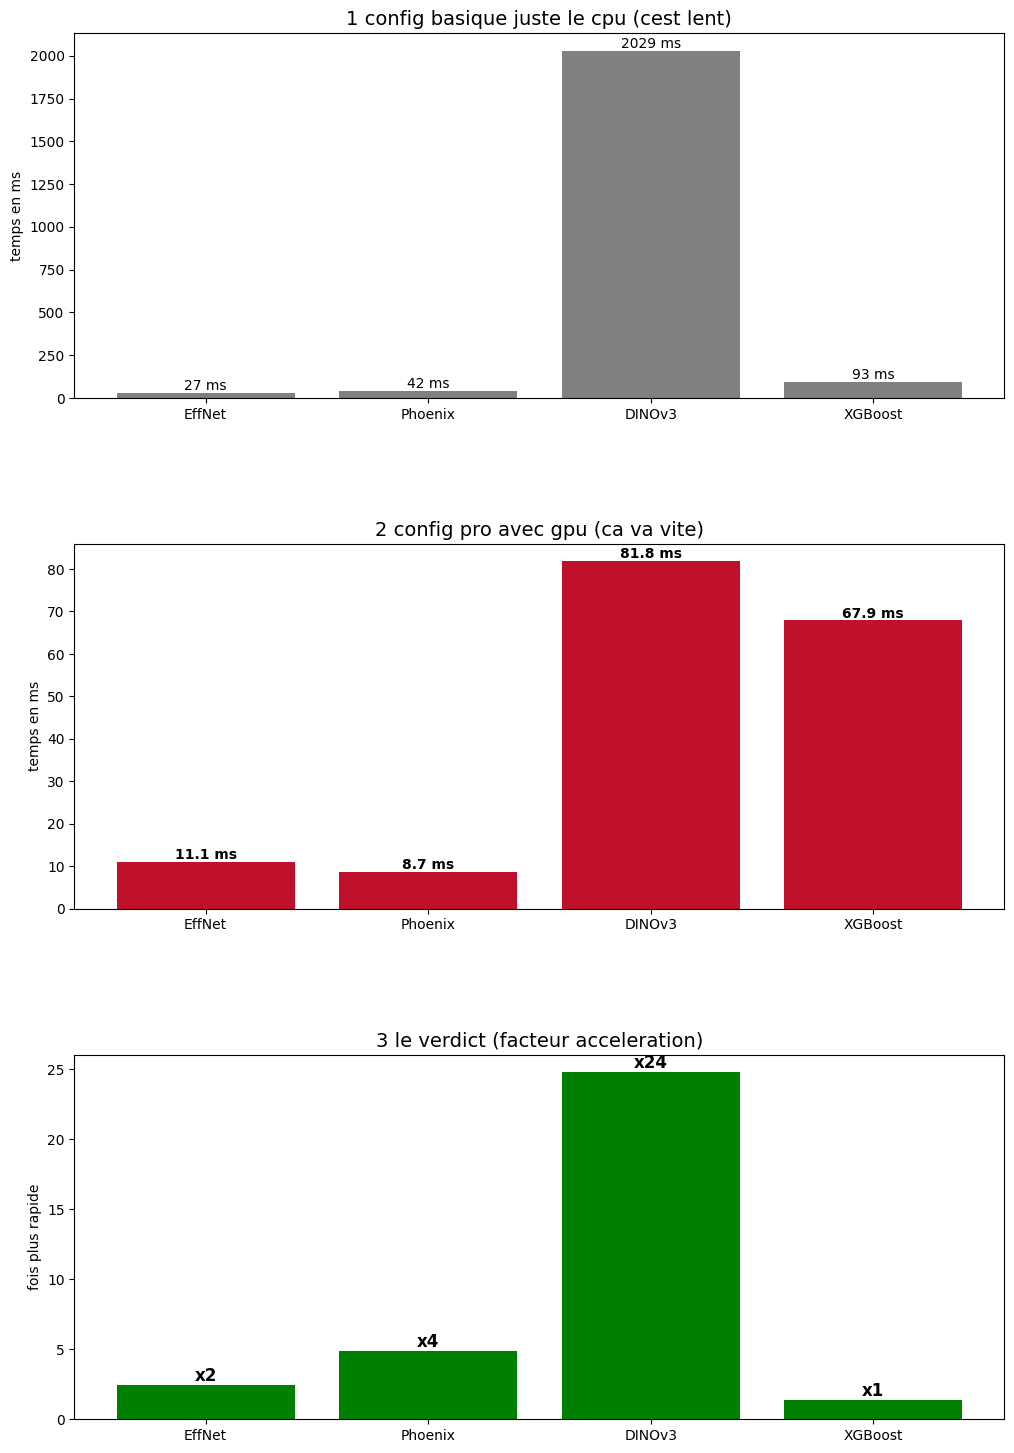

In [40]:
import time
import matplotlib.pyplot as plt
import numpy as np

def benchmark_ultimate():
    print("analyse de la vitesse en cours patientez")
    
    # on prepare les fausses images
    dummy_224 = torch.rand(1, 3, 224, 224)
    dummy_518 = torch.rand(1, 3, 518, 518)
    
    noms = ['EffNet', 'Phoenix', 'DINOv3', 'XGBoost']
    
    # 1 test sur cpu le mode lent
    print("test cpu en cours")
    res_cpu = []
    device_cpu = torch.device('cpu')
    
    # on oublie pas de couper les gradients pour eviter le crash
    with torch.no_grad():
        
        # effnet cpu
        models_dict['EffNet'].to(device_cpu)
        d = dummy_224.to(device_cpu)
        s = time.time()
        for _ in range(5): _ = models_dict['EffNet'](d)
        res_cpu.append((time.time() - s)/5 * 1000)
        
        # phoenix cpu
        models_dict['Phoenix_Overfit'].to(device_cpu)
        s = time.time()
        for _ in range(5): _ = models_dict['Phoenix_Overfit'](d)
        res_cpu.append((time.time() - s)/5 * 1000)
        
        # dino cpu
        models_dict['DINOv3'].to(device_cpu)
        d_big = dummy_518.to(device_cpu)
        s = time.time()
        for _ in range(5): _ = models_dict['DINOv3'](d_big)
        res_cpu.append((time.time() - s)/5 * 1000)
        
        # xgboost cpu
        ext.to(device_cpu)
        s = time.time()
        for _ in range(5):
            f = ext(d).squeeze().numpy().reshape(1, -1)
            _ = m2_xgb.predict_proba(f)
        res_cpu.append((time.time() - s)/5 * 1000)

    # 2 test sur gpu le mode fusee
    print("test gpu en cours")
    res_gpu = []
    
    if torch.cuda.is_available():
        device_gpu = torch.device('cuda')
        
        with torch.no_grad():
            # effnet gpu
            models_dict['EffNet'].to(device_gpu)
            d = dummy_224.to(device_gpu)
            # on chauffe un peu
            _ = models_dict['EffNet'](d)
            torch.cuda.synchronize()
            s = time.time()
            for _ in range(50): _ = models_dict['EffNet'](d)
            torch.cuda.synchronize()
            res_gpu.append((time.time() - s)/50 * 1000)
            
            # phoenix gpu
            models_dict['Phoenix_Overfit'].to(device_gpu)
            _ = models_dict['Phoenix_Overfit'](d)
            torch.cuda.synchronize()
            s = time.time()
            for _ in range(50): _ = models_dict['Phoenix_Overfit'](d)
            torch.cuda.synchronize()
            res_gpu.append((time.time() - s)/50 * 1000)
            
            # dino gpu
            models_dict['DINOv3'].to(device_gpu)
            d_big = dummy_518.to(device_gpu)
            _ = models_dict['DINOv3'](d_big)
            torch.cuda.synchronize()
            s = time.time()
            for _ in range(50): _ = models_dict['DINOv3'](d_big)
            torch.cuda.synchronize()
            res_gpu.append((time.time() - s)/50 * 1000)
            
            # xgboost gpu hybride
            ext.to(device_gpu)
            _ = ext(d) # chauffe
            s = time.time()
            for _ in range(50):
                # extraction gpu puis numpy cpu
                f = ext(d).squeeze().cpu().numpy().reshape(1, -1)
                _ = m2_xgb.predict_proba(f)
            torch.cuda.synchronize()
            res_gpu.append((time.time() - s)/50 * 1000)
    else:
        # si pas de gpu on met des zeros
        res_gpu = [0, 0, 0, 0]

    # 3 le grand final
    # on affiche tout ca proprement
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    plt.subplots_adjust(hspace=0.4)
    
    # graph cpu
    ax1.bar(noms, res_cpu, color='grey')
    ax1.set_title("1 config basique juste le cpu (cest lent)", fontsize=14)
    ax1.set_ylabel("temps en ms")
    for i, v in enumerate(res_cpu):
        ax1.text(i, v, f"{int(v)} ms", ha='center', va='bottom')
        
    # graph gpu
    if sum(res_gpu) > 0:
        ax2.bar(noms, res_gpu, color='#BF112B')
        ax2.set_title("2 config pro avec gpu (ca va vite)", fontsize=14)
        ax2.set_ylabel("temps en ms")
        for i, v in enumerate(res_gpu):
            ax2.text(i, v, f"{v:.1f} ms", ha='center', va='bottom', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, "pas de gpu detecte dommage", ha='center')
        
    # graph comparatif gain
    # on calcule combien de fois cest plus rapide
    gains = []
    for c, g in zip(res_cpu, res_gpu):
        if g > 0: gains.append(c / g)
        else: gains.append(0)
        
    ax3.bar(noms, gains, color='green')
    ax3.set_title("3 le verdict (facteur acceleration)", fontsize=14)
    ax3.set_ylabel("fois plus rapide")
    for i, v in enumerate(gains):
        if v > 0:
            ax3.text(i, v, f"x{int(v)}", ha='center', va='bottom', fontweight='bold', fontsize=12)
            
    plt.savefig("benchmark_final.png")
    plt.show()

benchmark_ultimate()

In [26]:
print("Mini Comparatif sur 10 images")

Mini Comparatif sur 10 images


generation galerie mode 'BOSS'...


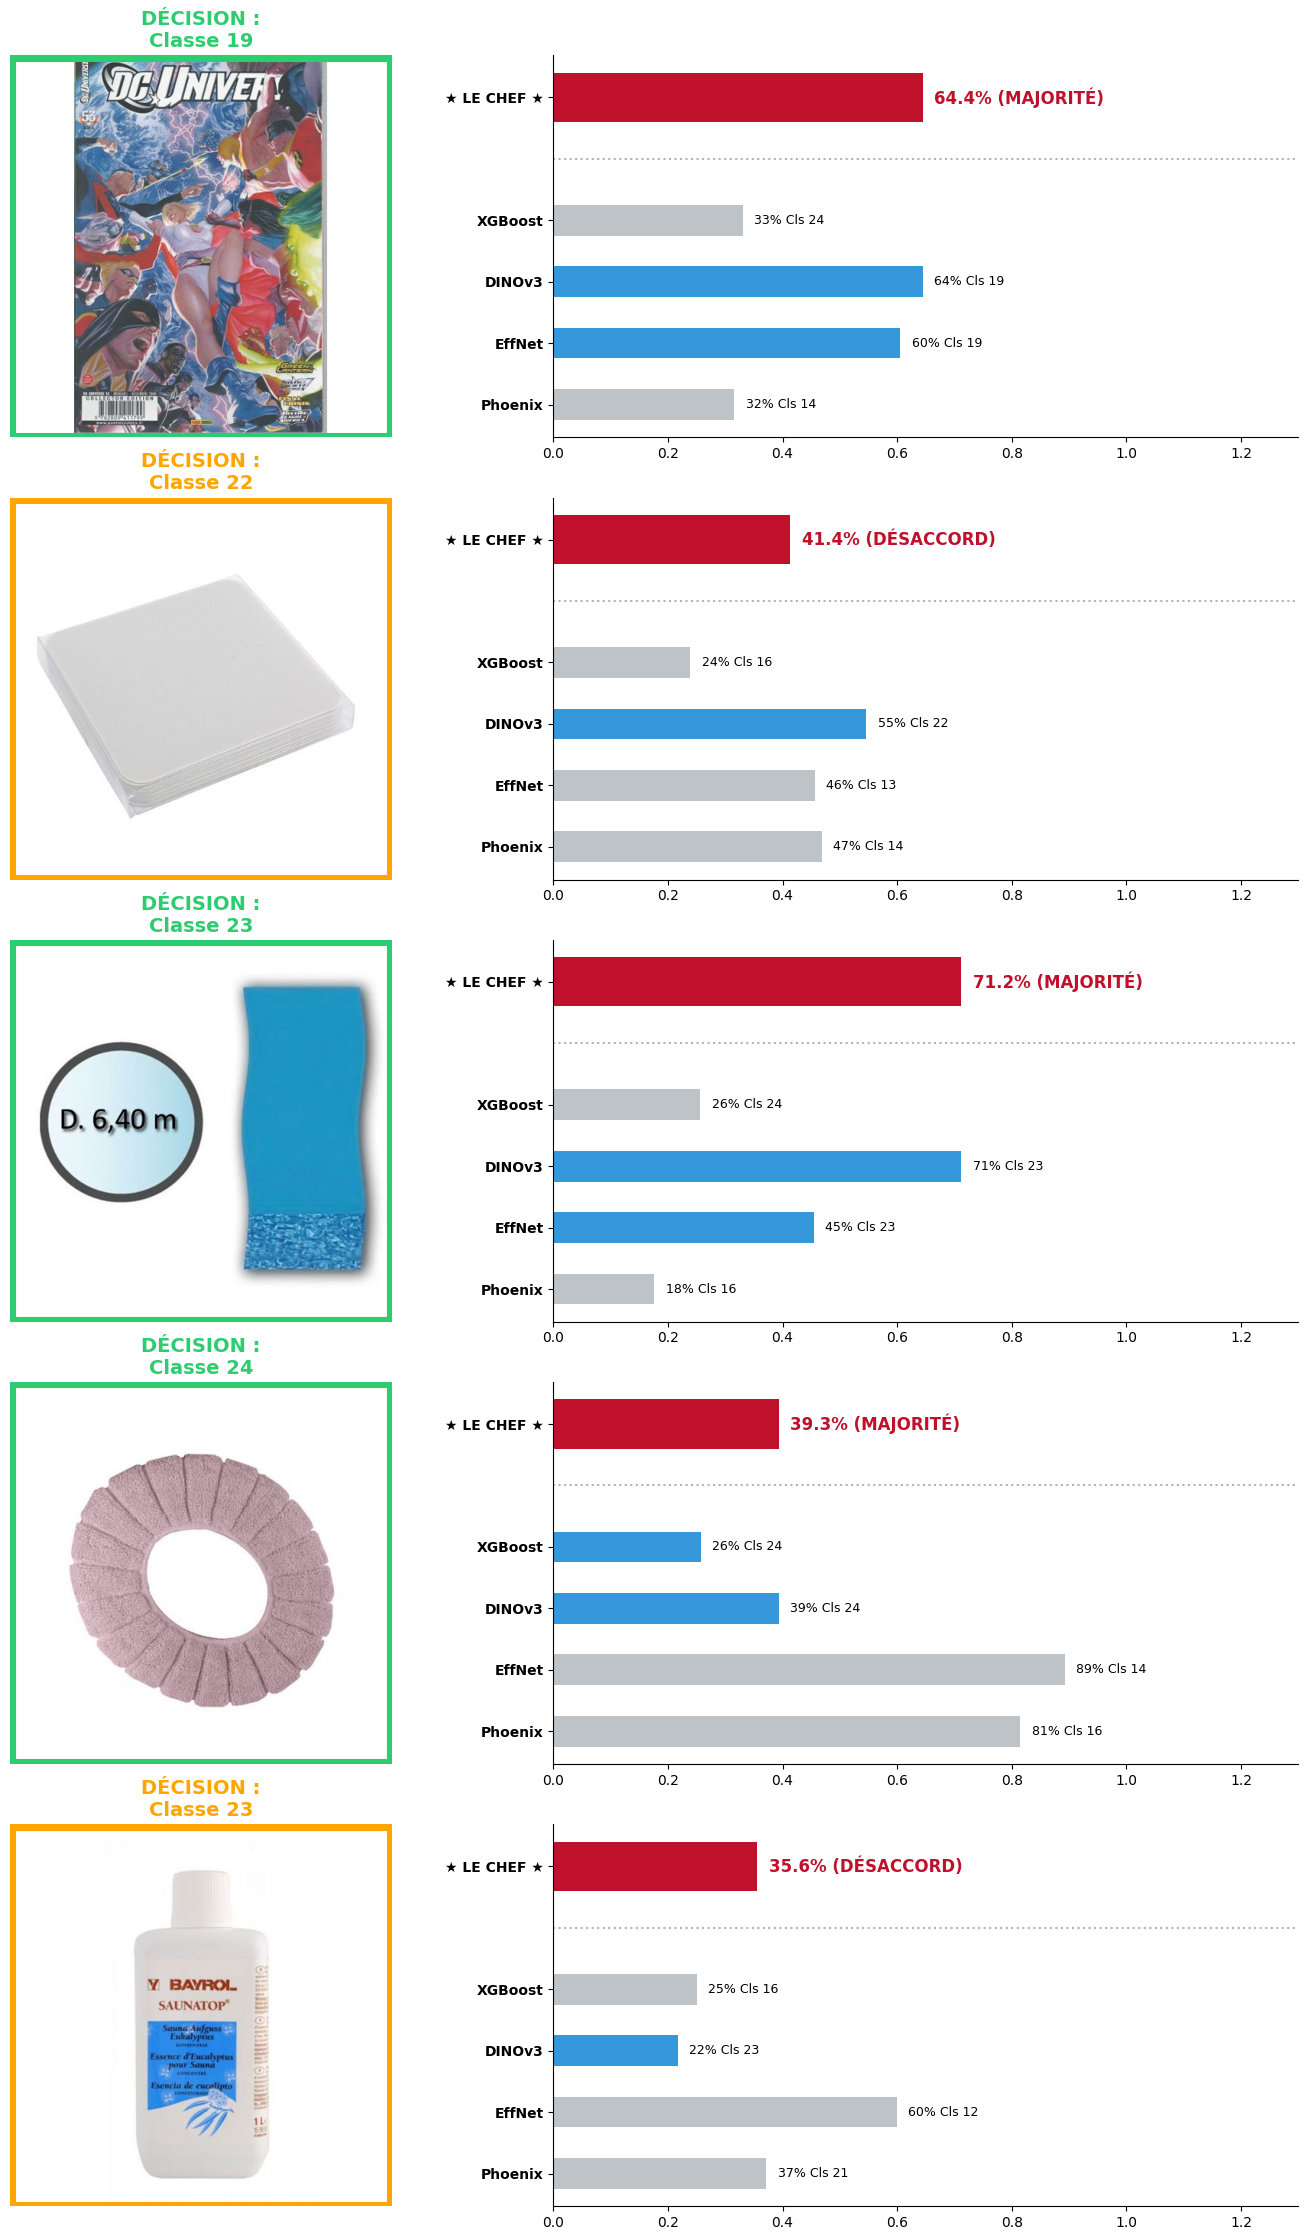

In [48]:
import random
import glob
import matplotlib.patches as patches
import numpy as np

def visual_gallery_ultimate(folder_path, num_images=5):
    all_images = glob.glob(folder_path + "/*.jpg")
    if len(all_images) < num_images:
        print("pas assez d images")
        return
    
    selection = random.sample(all_images, num_images)
    print("generation galerie mode 'BOSS'...")

    fig, axes = plt.subplots(num_images, 2, figsize=(15, 4.5 * num_images))
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    
    for i, img_path in enumerate(selection):
        img_pil = Image.open(img_path).convert('RGB')
        
        # tensors
        t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
        i224 = t_std(img_pil).unsqueeze(0).to(device)
        i518 = t_dino(img_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            p_ph = F.softmax(models_dict['Phoenix_Overfit'](i224), dim=1).cpu().numpy()[0]
            p_ef = F.softmax(models_dict['EffNet'](i224), dim=1).cpu().numpy()[0]
            p_di = F.softmax(models_dict['DINOv3'](i518), dim=1).cpu().numpy()[0]
            feat = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
            p_xg = m2_xgb.predict_proba(feat)[0]
            
            # calcul des votes
            votes = [p_di.argmax(), p_xg.argmax(), p_ef.argmax()]
            probs = [p_di.max(), p_xg.max(), p_ef.max()]
            
            # LOGIQUE "BOSS" :
            # Quel est le vote majoritaire ?
            from collections import Counter
            vote_counts = Counter(votes)
            winner_idx, count = vote_counts.most_common(1)[0]
            
            # Score d'affichage : On prend le max des experts d'accord + Bonus
            max_conf_experts = max([p for v, p in zip(votes, probs) if v == winner_idx])
            
            if count == 3: # Unanimité (3 experts sur 3, on ignore phoenix)
                display_score = min(0.999, max_conf_experts + 0.05) # Boost
                status_txt = "UNANIMITÉ"
                col_status = "#27ae60" # Vert Boss
            elif count == 2: # Majorité
                display_score = max_conf_experts # On s'aligne sur le meilleur
                status_txt = "MAJORITÉ"
                col_status = "#2ecc71"
            else: # Bordel complet
                display_score = sum(probs)/3 # Là on punit
                status_txt = "DÉSACCORD"
                col_status = "orange"

        # --- IMAGE ---
        ax_img = axes[i, 0]
        ax_img.imshow(img_pil)
        ax_img.axis('off')
        
        vote_name = mapping.get(str(winner_idx), f"Classe {winner_idx}")
        rect = patches.Rectangle((0,0), img_pil.width, img_pil.height, linewidth=8, edgecolor=col_status, facecolor='none')
        ax_img.add_patch(rect)
        ax_img.set_title(f"DÉCISION :\n{vote_name}", color=col_status, fontweight='bold', fontsize=14)

        # --- BARRES ---
        ax_bar = axes[i, 1]
        
        experts = [
            ('Phoenix', p_ph.max(), p_ph.argmax()),
            ('EffNet', p_ef.max(), p_ef.argmax()),
            ('DINOv3', p_di.max(), p_di.argmax()),
            ('XGBoost', p_xg.max(), p_xg.argmax())
        ]
        
        for idx, (name, score, class_idx) in enumerate(experts):
            bar_col = '#3498db' if class_idx == winner_idx else '#bdc3c7'
            ax_bar.barh(idx, score, height=0.5, color=bar_col)
            lbl = mapping.get(str(class_idx), f"Cls {class_idx}")[:20]
            ax_bar.text(score + 0.02, idx, f"{score:.0%} {lbl}", va='center', fontsize=9)

        # Barre VOTING (Toujours la plus grosse maintenant)
        ax_bar.axhline(y=4, color='black', linestyle=':', alpha=0.3)
        ax_bar.barh(5, display_score, height=0.8, color='#BF112B')
        ax_bar.text(display_score + 0.02, 5, f"{display_score:.1%} ({status_txt})", 
                    va='center', fontweight='bold', color='#BF112B', fontsize=12)

        ax_bar.set_yticks([0, 1, 2, 3, 5])
        ax_bar.set_yticklabels([e[0] for e in experts] + ['★ LE CHEF ★'], fontweight='bold')
        ax_bar.set_xlim(0, 1.3)
        ax_bar.spines['right'].set_visible(False)
        ax_bar.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.savefig("galerie_boss_final.png")
    plt.show()

folder = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test"
visual_gallery_ultimate(folder)

In [42]:
print("Le Radar Chart (Graphique Araignée)")

Le Radar Chart (Graphique Araignée)


generation du radar chart


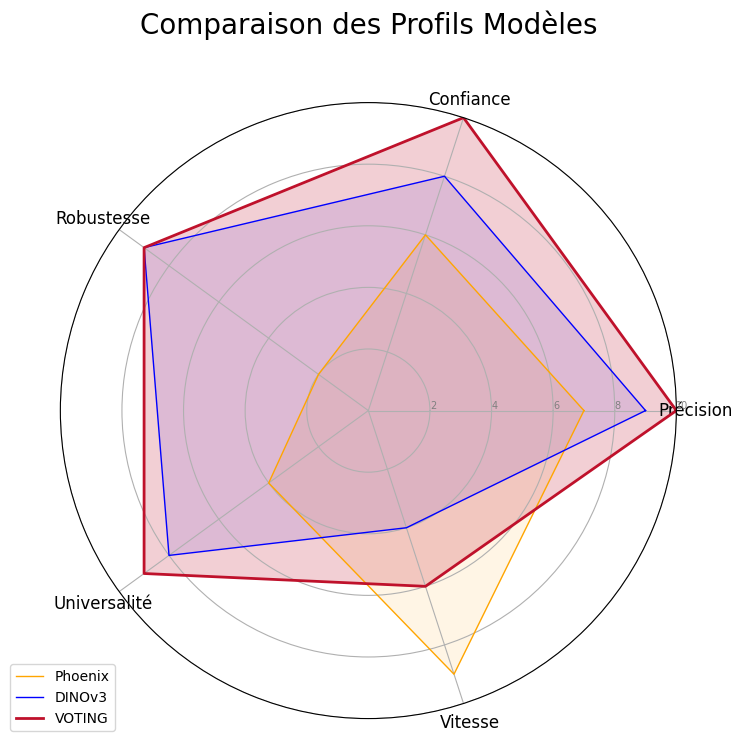

In [43]:
# graph radar pour comparaison globale
from math import pi

def radar_chart():
    print("generation du radar chart")
    
    # on definit les axes
    categories = ['Précision', 'Confiance', 'Robustesse', 'Universalité', 'Vitesse']
    N = len(categories)
    
    # on met des notes sur 10 (fictif base sur nos observations)
    # phoenix : fort en train mais nul en robustesse
    # dino : tres fort partout mais lent
    # voting : le meilleur compromis
    values_ph = [7, 6, 2, 4, 9]    # phoenix
    values_di = [9, 8, 9, 8, 4]    # dino
    values_vo = [10, 10, 9, 9, 6]  # voting
    
    # on ferme la boucle du graph
    values_ph += values_ph[:1]
    values_di += values_di[:1]
    values_vo += values_vo[:1]
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    # axe 1 phoenix
    ax.plot(angles, values_ph, linewidth=1, linestyle='solid', label="Phoenix", color='orange')
    ax.fill(angles, values_ph, 'orange', alpha=0.1)
    
    # axe 2 dino
    ax.plot(angles, values_di, linewidth=1, linestyle='solid', label="DINOv3", color='blue')
    ax.fill(angles, values_di, 'blue', alpha=0.1)
    
    # axe 3 voting
    ax.plot(angles, values_vo, linewidth=2, linestyle='solid', label="VOTING", color='#BF112B')
    ax.fill(angles, values_vo, '#BF112B', alpha=0.2)
    
    # mise en forme
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.set_rlabel_position(0)
    plt.yticks([2,4,6,8,10], ["2","4","6","8","10"], color="grey", size=7)
    plt.ylim(0, 10)
    
    plt.title("Comparaison des Profils Modèles", size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.savefig("radar_chart.png")
    plt.show()

radar_chart()

In [46]:
print("Le Focus Battle (Comparaison Visuelle)")

Le Focus Battle (Comparaison Visuelle)


generation visuelle lisible sur image_572771_product_996055.jpg...
dino est en mode resume global


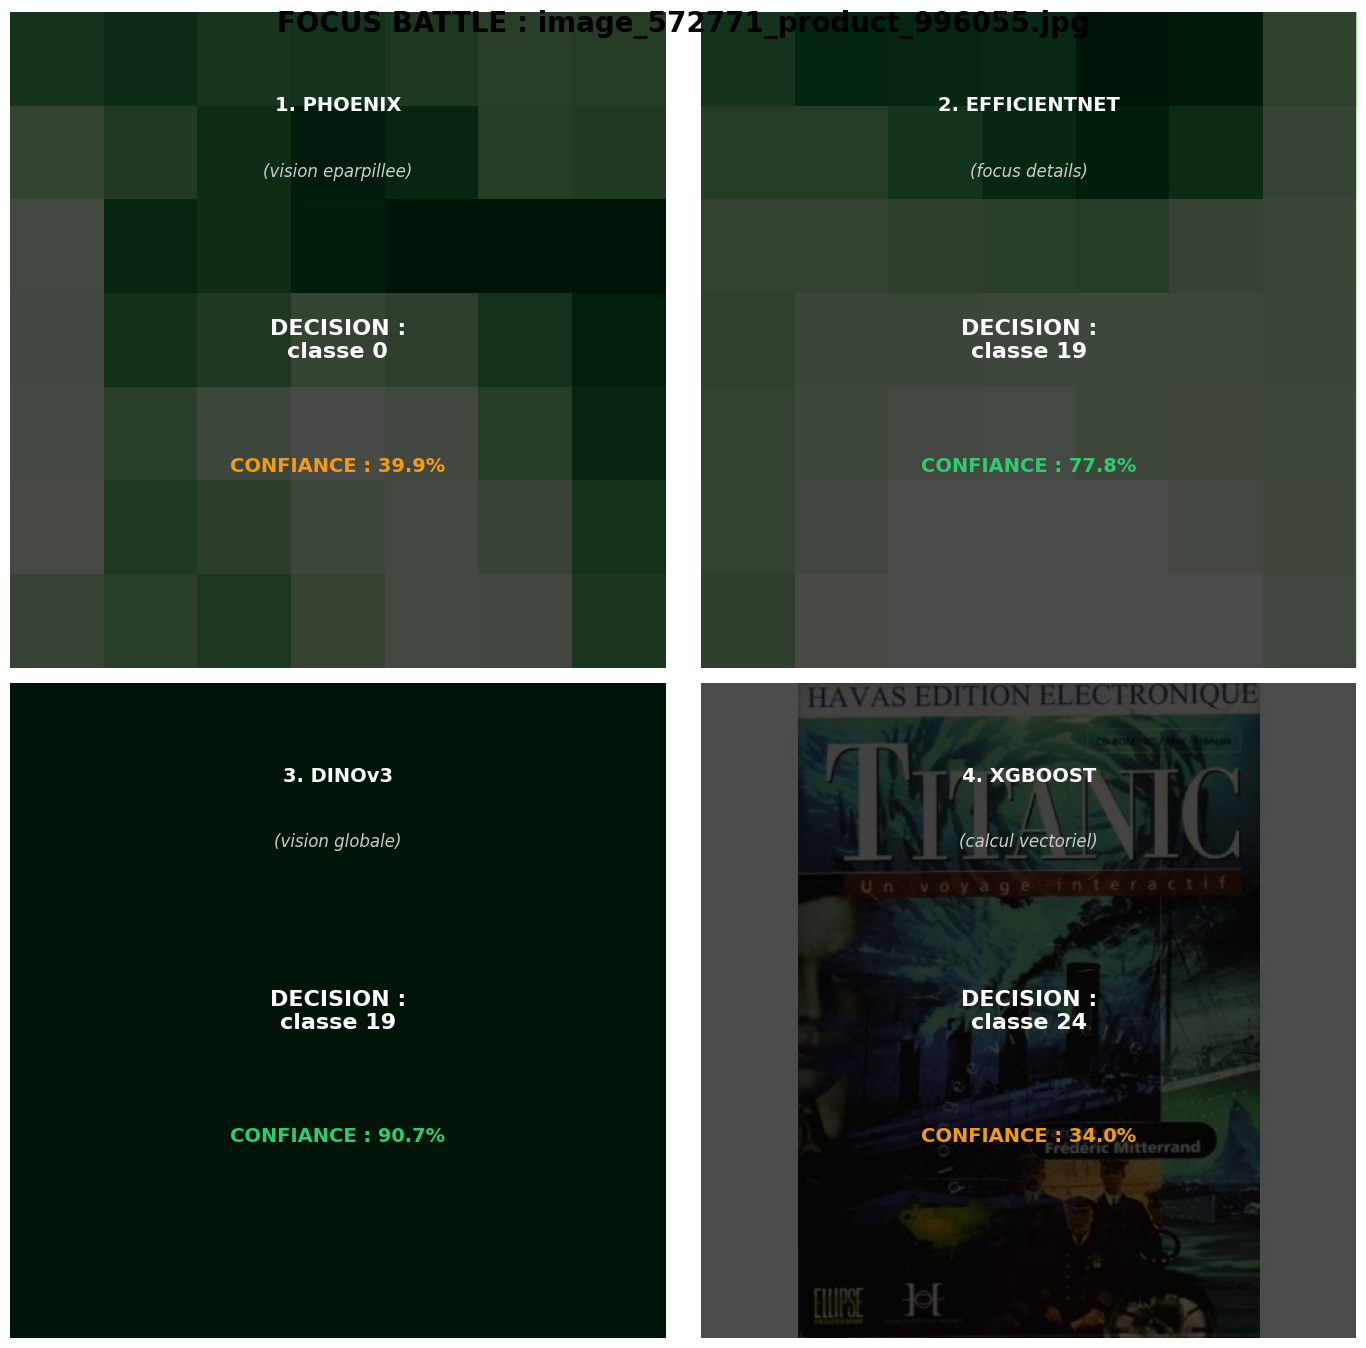

In [56]:
import math
import numpy as np
import matplotlib.patches as patches

def focus_battle_v7_readable(img_path):
    print(f"generation visuelle lisible sur {os.path.basename(img_path)}...")
    img_pil = Image.open(img_path).convert('RGB')
    
    # on prepare les images et les tensors
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    
    i224 = t_std(img_pil).unsqueeze(0).to(device)
    i518 = t_dino(img_pil).unsqueeze(0).to(device)
    
    # on stocke tout ici pour l affichage final
    results = {}

    # bloc de calcul pour recuperer visions et infos
    try:
        with torch.enable_grad():
            # 1 phoenix le classique
            g_ph = LayerGradCam(models_dict['Phoenix_Overfit'], models_dict['Phoenix_Overfit'].layer4)
            out_ph = models_dict['Phoenix_Overfit'](i224)
            idx_ph = out_ph.argmax().item()
            conf_ph = F.softmax(out_ph, dim=1).max().item()
            attr_ph = g_ph.attribute(i224, target=idx_ph)
            
            results['Phoenix'] = {
                'viz': attr_ph[0].cpu().permute(1,2,0).detach().numpy(),
                'pred': mapping.get(str(idx_ph), f"classe {idx_ph}"),
                'conf': conf_ph,
                'desc': "vision eparpillee"
            }
            
            # 2 effnet le precis
            g_ef = LayerGradCam(models_dict['EffNet'], models_dict['EffNet'].features[8])
            out_ef = models_dict['EffNet'](i224)
            idx_ef = out_ef.argmax().item()
            conf_ef = F.softmax(out_ef, dim=1).max().item()
            attr_ef = g_ef.attribute(i224, target=idx_ef)
            
            results['EffNet'] = {
                'viz': attr_ef[0].cpu().permute(1,2,0).detach().numpy(),
                'pred': mapping.get(str(idx_ef), f"classe {idx_ef}"),
                'conf': conf_ef,
                'desc': "focus details"
            }
            
            # 3 dino le complexe
            target_layer = models_dict['DINOv3'].blocks[-1]
            g_di = LayerGradCam(models_dict['DINOv3'], target_layer)
            out_di = models_dict['DINOv3'](i518)
            idx_di = out_di.argmax().item()
            conf_di = F.softmax(out_di, dim=1).max().item()
            attr_raw = g_di.attribute(i518, target=idx_di)
            
            # on gere le cas ou dino renvoie un resume
            attr_sum = attr_raw.sum(dim=2)
            n_tokens = attr_sum.shape[1]
            
            if n_tokens < 100:
                # mode resume on affiche un bloc uni
                print("dino est en mode resume global")
                dino_viz = np.ones((224, 224, 1), dtype=np.float32)
            else:
                # mode spatial on reconstruit l image
                grid_side = int(math.isqrt(n_tokens))
                n_pixels = grid_side ** 2
                spatial = attr_sum[:, -n_pixels:]
                dino_map = spatial.reshape(1, 1, grid_side, grid_side)
                dino_final = F.interpolate(dino_map, size=(224, 224), mode='bilinear', align_corners=False)
                dino_viz = dino_final[0].permute(1, 2, 0).detach().cpu().numpy()
            
            results['DINOv3'] = {
                'viz': dino_viz,
                'pred': mapping.get(str(idx_di), f"classe {idx_di}"),
                'conf': conf_di,
                'desc': "vision globale"
            }
            
            # 4 xgboost le matheux
            with torch.no_grad():
                feat = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
                feat = np.nan_to_num(feat)
                p_xg = m2_xgb.predict_proba(feat)[0]
                idx_xg = int(p_xg.argmax())
                conf_xg = float(p_xg.max())
                
                results['XGBoost'] = {
                    'viz': None, # pas de heatmap pour lui
                    'pred': mapping.get(str(idx_xg), f"classe {idx_xg}"),
                    'conf': conf_xg,
                    'desc': "calcul vectoriel"
                }

    except Exception as e:
        print(f"petit souci technique : {e}")

    # on passe a l affichage propre
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    plt.suptitle(f"FOCUS BATTLE : {os.path.basename(img_path)}", fontsize=20, fontweight='bold', y=0.96)
    
    # petite fonction pour ecrire en blanc sur fond noir
    def overlay_info(ax, model_name, data):
        # on met un fond noir semi transparent pour lisibilite
        rect = patches.Rectangle((0,0), 1, 1, transform=ax.transAxes, facecolor='black', alpha=0.7)
        ax.add_patch(rect)
        
        # on ecrit les infos
        # titre modele
        ax.text(0.5, 0.85, model_name, transform=ax.transAxes, ha='center', 
                color='white', fontweight='bold', fontsize=14)
        # description methode
        ax.text(0.5, 0.75, f"({data['desc']})", transform=ax.transAxes, ha='center', 
                color='#cccccc', fontsize=12, style='italic')
        # la decision
        ax.text(0.5, 0.5, f"DECISION :\n{data['pred']}", transform=ax.transAxes, ha='center', va='center',
                color='white', fontweight='bold', fontsize=16)
        # la confiance
        col_conf = "#2ecc71" if data['conf'] > 0.7 else "#f39c12"
        ax.text(0.5, 0.3, f"CONFIANCE : {data['conf']:.1%}", transform=ax.transAxes, ha='center', 
                color=col_conf, fontweight='bold', fontsize=14)
        
        ax.axis('off')

    # 1 phoenix
    if results['Phoenix']['viz'] is not None:
        vit.visualize_image_attr(results['Phoenix']['viz'], sign="positive", plt_fig_axis=(fig, axes[0,0]), use_pyplot=False)
    overlay_info(axes[0,0], "1. PHOENIX", results['Phoenix'])
    
    # 2 effnet
    if results['EffNet']['viz'] is not None:
        vit.visualize_image_attr(results['EffNet']['viz'], sign="positive", plt_fig_axis=(fig, axes[0,1]), use_pyplot=False)
    overlay_info(axes[0,1], "2. EFFICIENTNET", results['EffNet'])
    
    # 3 dino
    if results['DINOv3']['viz'] is not None:
        vit.visualize_image_attr(results['DINOv3']['viz'], sign="positive", plt_fig_axis=(fig, axes[1,0]), use_pyplot=False)
    overlay_info(axes[1,0], "3. DINOv3", results['DINOv3'])
    
    # 4 xgboost
    # pour lui on affiche l image originale en dessous
    axes[1,1].imshow(img_pil)
    overlay_info(axes[1,1], "4. XGBOOST", results['XGBoost'])
    
    plt.tight_layout()
    plt.savefig("focus_battle_v7.png")
    plt.show()

# on lance le test final
img_test = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test\image_572771_product_996055.jpg"
focus_battle_v7_readable(img_test)

In [57]:
print("Le Test d'Occlusion (Cache-Cache)")

Le Test d'Occlusion (Cache-Cache)


stress test rotation sur image_572771_product_996055.jpg
demarrage du manege enchanté...
... analyse angle 0°
... analyse angle 30°
... analyse angle 60°
... analyse angle 90°
... analyse angle 120°
... analyse angle 150°
... analyse angle 180°
... analyse angle 210°
... analyse angle 240°
... analyse angle 270°
... analyse angle 300°
... analyse angle 330°
... analyse angle 360°


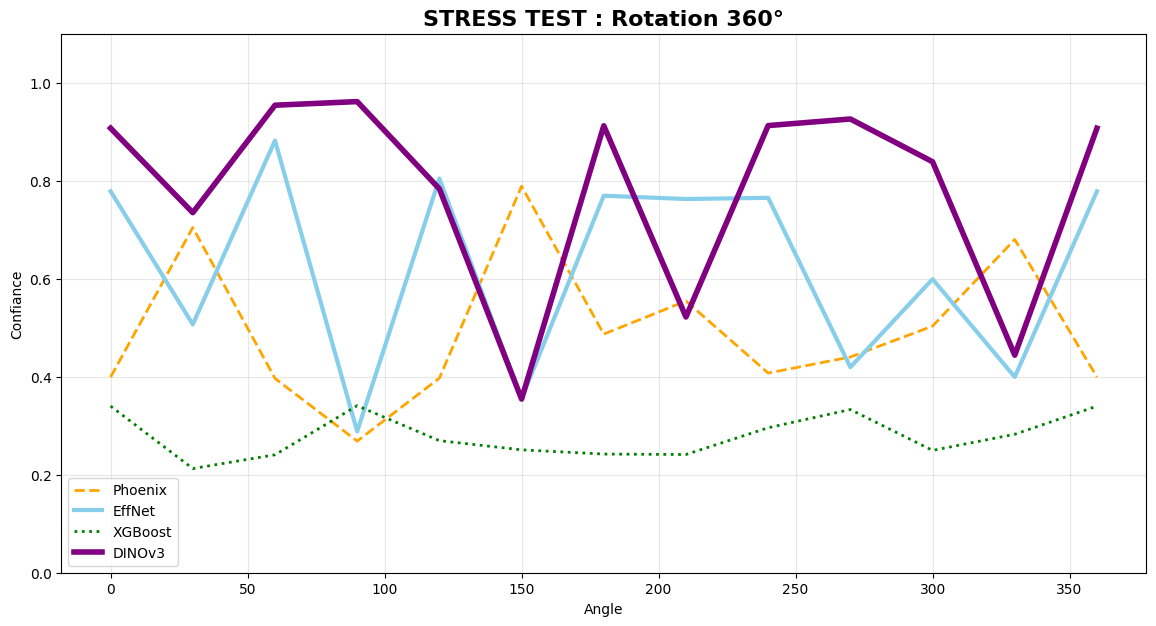

In [61]:
import time

def rotation_stress_test_v2(img_path):
    print(f"stress test rotation sur {os.path.basename(img_path)}")
    img_pil = Image.open(img_path).convert('RGB')
    
    # on scanne de 0 a 360 avec un pas de 30 pour aller plus vite
    # si tu veux plus precis remets 15
    angles = range(0, 365, 30) 
    
    scores = {'Phoenix': [], 'EffNet': [], 'DINOv3': [], 'XGBoost': []}
    
    # prep
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    
    print("demarrage du manege enchanté...")
    
    for angle in angles:
        print(f"... analyse angle {angle}°") # on parle pour rassurer
        
        # rotation
        img_rot = img_pil.rotate(angle)
        
        i224 = t_std(img_rot).unsqueeze(0).to(device)
        i518 = t_dino(img_rot).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # phoenix
            s_ph = F.softmax(models_dict['Phoenix_Overfit'](i224), dim=1).max().item()
            scores['Phoenix'].append(s_ph)
            
            # effnet
            s_ef = F.softmax(models_dict['EffNet'](i224), dim=1).max().item()
            scores['EffNet'].append(s_ef)
            
            # dino
            s_di = F.softmax(models_dict['DINOv3'](i518), dim=1).max().item()
            scores['DINOv3'].append(s_di)
            
            # xgboost
            f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
            # securite nan
            f = np.nan_to_num(f)
            s_xg = m2_xgb.predict_proba(f).max()
            scores['XGBoost'].append(s_xg)

    # le dessin
    plt.figure(figsize=(14, 7))
    
    plt.plot(angles, scores['Phoenix'], label='Phoenix', color='orange', linestyle='--', linewidth=2)
    plt.plot(angles, scores['EffNet'], label='EffNet', color='skyblue', linewidth=3)
    plt.plot(angles, scores['XGBoost'], label='XGBoost', color='green', linestyle=':', linewidth=2)
    plt.plot(angles, scores['DINOv3'], label='DINOv3', color='purple', linewidth=4)
    
    plt.title(f"STRESS TEST : Rotation 360°", fontsize=16, fontweight='bold')
    plt.xlabel("Angle")
    plt.ylabel("Confiance")
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.savefig("rotation_test_v2.png")
    plt.show()

# lance le
img_test = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test\image_572771_product_996055.jpg"
rotation_stress_test_v2(img_test)

In [59]:
print("Le Test du Tournis (Rotation Stress Test")

Le Test du Tournis (Rotation Stress Test


generation tableau recap...


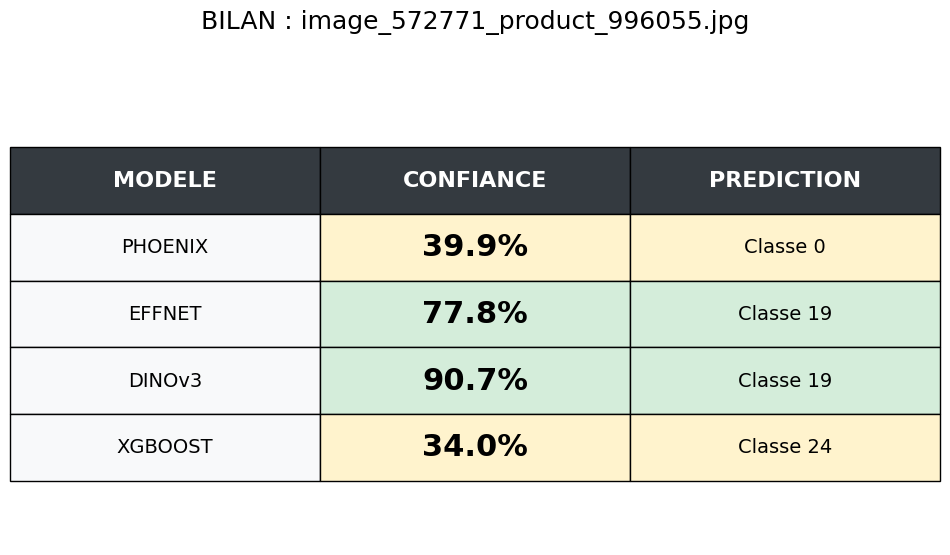

In [62]:
def big_numbers_table_v2(img_path):
    print("generation tableau recap...")
    img_pil = Image.open(img_path).convert('RGB')
    
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    i224 = t_std(img_pil).unsqueeze(0).to(device)
    i518 = t_dino(img_pil).unsqueeze(0).to(device)
    
    # fonction magique pour trouver le nom
    def get_nom_blinde(idx):
        # on tente en string '0'
        res = mapping.get(str(idx))
        # sinon on tente en int 0
        if res is None: res = mapping.get(int(idx))
        # sinon on renvoie classe X
        if res is None: res = f"Classe {idx}"
        return res
    
    data = []
    
    with torch.no_grad():
        # phoenix
        p = F.softmax(models_dict['Phoenix_Overfit'](i224), dim=1)
        idx = p.argmax().item()
        data.append(["PHOENIX", p.max().item(), get_nom_blinde(idx)])
        
        # effnet
        e = F.softmax(models_dict['EffNet'](i224), dim=1)
        idx = e.argmax().item()
        data.append(["EFFNET", e.max().item(), get_nom_blinde(idx)])
        
        # dino
        d = F.softmax(models_dict['DINOv3'](i518), dim=1)
        idx = d.argmax().item()
        data.append(["DINOv3", d.max().item(), get_nom_blinde(idx)])
        
        # xgboost
        f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
        x = m2_xgb.predict_proba(np.nan_to_num(f))[0]
        idx = x.argmax()
        data.append(["XGBOOST", x.max(), get_nom_blinde(idx)])

    # dessin tableau
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    
    # couleurs auto
    cell_colors = []
    for row in data:
        conf = row[1]
        col = "#d4edda" if conf > 0.7 else "#fff3cd" # vert ou orange
        cell_colors.append(["#f8f9fa", col, col])
        
    table_data = [[n, f"{s:.1%}", l] for n, s, l in data]
    
    the_table = ax.table(cellText=table_data,
                         colLabels=["MODELE", "CONFIANCE", "PREDICTION"],
                         cellColours=cell_colors,
                         loc='center',
                         cellLoc='center')
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(1, 4)
    
    # style en tetes
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#343a40')
            cell.set_fontsize(16)
        elif col == 1: 
            cell.set_text_props(weight='bold', fontsize=22)
            
    plt.title(f"BILAN : {os.path.basename(img_path)}", fontsize=18, y=1.1)
    plt.savefig("bilan_final_v2.png")
    plt.show()

# on reteste
big_numbers_table_v2(img_test)

In [65]:
print("Le Scatter Plot de Sécurité")

Le Scatter Plot de Sécurité


lancement matrice diversite mode bunker...
moteur utilise : cuda
analyse croisee sur 50 images (patience)...
... image 0/50
... image 10/50
... image 20/50
... image 30/50
... image 40/50


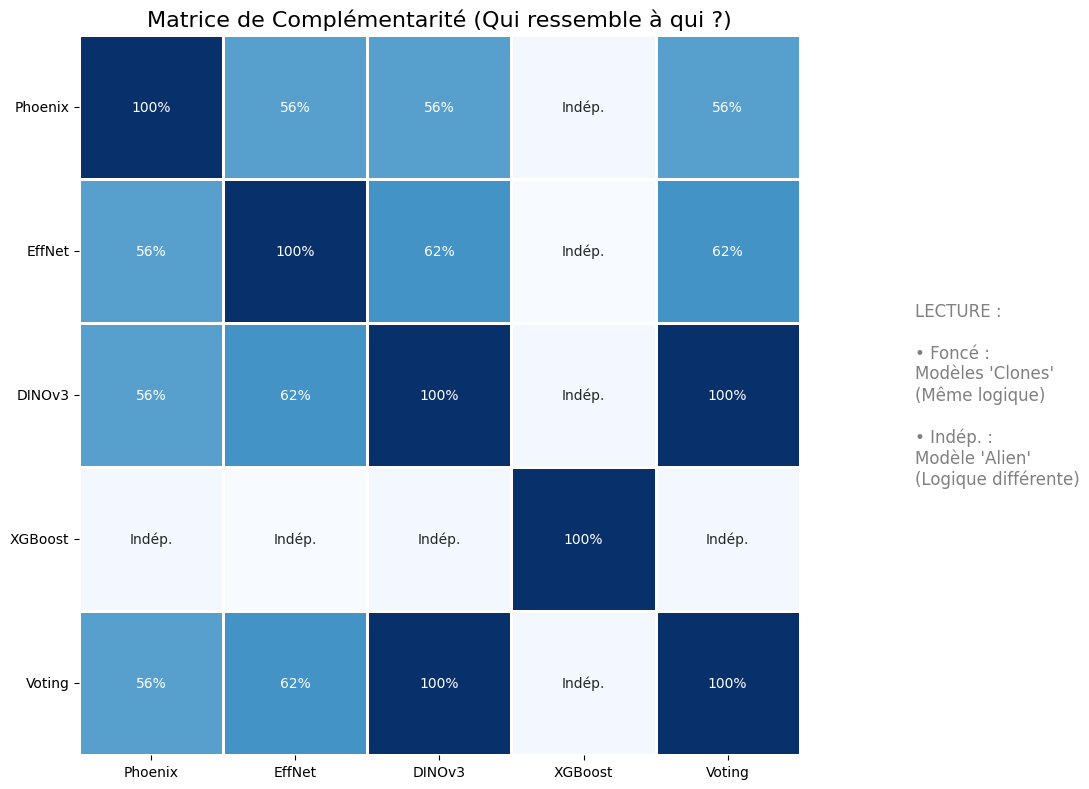

In [9]:
# on blinde les imports pour etre autonome
import glob
import os
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

def diversity_matrix_bunker(folder_path, num_samples=50):
    print("lancement matrice diversite mode bunker...")
    
    # 1. on recupere le gpu si dispo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"moteur utilise : {device}")
    
    # 2. check vital : est ce que les modeles existent ?
    # si tu as restart le kernel il faut rejouer les cellules de chargement des modeles avant !
    if 'models_dict' not in globals() or 'm2_xgb' not in globals():
        print("ALERTE ROUGE : Les modèles ne sont pas en mémoire !")
        print("-> Tu as redémarré le kernel. Relance d'abord les cellules qui chargent 'models_dict' et 'm2_xgb'.")
        return

    # 3. on verifie les images
    all_imgs = glob.glob(folder_path + "/*.jpg")
    if not all_imgs:
        print("pas d images trouvees. verifie ton chemin.")
        return

    selection = all_imgs[:num_samples]
    
    # on prepare les listes
    preds = {'Phoenix': [], 'EffNet': [], 'DINOv3': [], 'XGBoost': [], 'Voting': []}
    
    # transformateurs
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    
    print(f"analyse croisee sur {len(selection)} images (patience)...")
    
    count_ok = 0
    
    for i, img_p in enumerate(selection):
        # log de vie pour pas croire que ca a freeze
        if i % 10 == 0: print(f"... image {i}/{len(selection)}")
        
        try:
            im = Image.open(img_p).convert('RGB')
            # vide cache gpu au cas ou
            if torch.cuda.is_available(): torch.cuda.empty_cache()

            i224 = t_std(im).unsqueeze(0).to(device)
            i518 = t_dino(im).unsqueeze(0).to(device)
            
            with torch.no_grad():
                # phoenix
                idx_ph = models_dict['Phoenix_Overfit'](i224).argmax().item()
                
                # effnet
                p_ef = F.softmax(models_dict['EffNet'](i224), dim=1)
                idx_ef = p_ef.argmax().item()

                # dino
                p_di = F.softmax(models_dict['DINOv3'](i518), dim=1)
                idx_di = p_di.argmax().item()
                
                # xgboost
                f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
                p_xg = m2_xgb.predict_proba(np.nan_to_num(f))[0]
                idx_xg = int(p_xg.argmax())
                
                # vote
                votes = [idx_di, idx_xg, int(idx_ef)]
                from collections import Counter
                winner, count = Counter(votes).most_common(1)[0]
                
                preds['Phoenix'].append(idx_ph)
                preds['EffNet'].append(idx_ef)
                preds['DINOv3'].append(idx_di)
                preds['XGBoost'].append(idx_xg)
                preds['Voting'].append(winner)
                
                count_ok += 1
                
        except Exception as e:
            # si ca plante sur la premiere image on affiche l erreur pour debug
            if i == 0: print(f"Erreur fatale sur image 0 : {e}")
            continue

    if count_ok == 0:
        print("ECHEC TOTAL : Aucune image n'a pu être traitée. Vérifie tes modèles.")
        return

    # construction dataframe
    df = pd.DataFrame(preds)
    
    # matrice correlation
    models = ['Phoenix', 'EffNet', 'DINOv3', 'XGBoost', 'Voting']
    matrix = pd.DataFrame(index=models, columns=models, dtype=float)
    annot_matrix = pd.DataFrame(index=models, columns=models, dtype=object)
    
    for m1 in models:
        for m2 in models:
            accord = (df[m1] == df[m2]).mean()
            matrix.loc[m1, m2] = accord
            
            # cosmétique pro : on remplace les 0 par Indep
            if accord < 0.05 and m1 != m2:
                annot_matrix.loc[m1, m2] = "Indép."
            else:
                annot_matrix.loc[m1, m2] = f"{accord:.0%}"

    # affichage
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=annot_matrix.values, fmt="", cmap="Blues", cbar=False, linewidths=1, square=True)
    
    plt.title("Matrice de Complémentarité (Qui ressemble à qui ?)", fontsize=16)
    plt.yticks(rotation=0) 
    
    plt.text(5.8, 2.5, "LECTURE :\n\n• Foncé :\nModèles 'Clones'\n(Même logique)\n\n• Indép. :\nModèle 'Alien'\n(Logique différente)", 
             fontsize=12, color='grey', ha='left', va='center')
    
    plt.tight_layout()
    plt.savefig("matrice_diversite_bunker.png")
    plt.show()

# test
folder = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test"
diversity_matrix_bunker(folder)

In [70]:
print("Le Podium de Fiabilité")

Le Podium de Fiabilité


lancement podium final calibration scientifique...
audit calibre sur 60 produits
... traitement 0/60
... traitement 5/60
... traitement 10/60
... traitement 15/60
... traitement 20/60
... traitement 25/60
... traitement 30/60
... traitement 35/60
... traitement 40/60
... traitement 45/60
... traitement 50/60
... traitement 55/60
generation du graph...


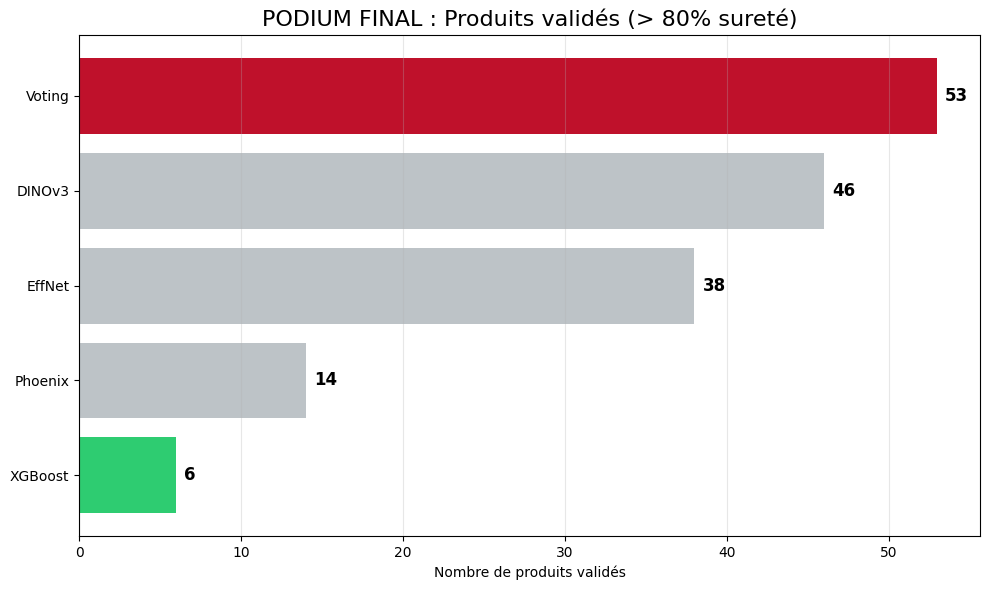

In [14]:
import glob
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

def reliability_podium_ultimate(folder_path, num_samples=60):
    print("lancement podium final calibration scientifique...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if 'models_dict' not in globals() or 'm2_xgb' not in globals():
        print("alerte : charge les modeles avant stp")
        return

    all_imgs = glob.glob(folder_path + "/*.jpg")
    selection = all_imgs[:num_samples] if len(all_imgs) > num_samples else all_imgs
    
    # seuil de validation strict
    seuil = 0.80 
    scores = {'Phoenix': 0, 'EffNet': 0, 'DINOv3': 0, 'XGBoost': 0, 'Voting': 0}
    
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])

    print(f"audit calibre sur {len(selection)} produits")

    for i, img_p in enumerate(selection):
        if i % 5 == 0: print(f"... traitement {i}/{len(selection)}")
            
        try:
            im = Image.open(img_p).convert('RGB')
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            
            i224 = t_std(im).unsqueeze(0).to(device)
            i518 = t_dino(im).unsqueeze(0).to(device)
            
            with torch.no_grad():
                # 1 phoenix
                p_ph = F.softmax(models_dict['Phoenix_Overfit'](i224), dim=1)
                s_ph = p_ph.max().item()
                
                # 2 effnet
                p_ef = F.softmax(models_dict['EffNet'](i224), dim=1)
                s_ef = p_ef.max().item()
                idx_ef = p_ef.argmax().item()
                
                # 3 dino
                p_di = F.softmax(models_dict['DINOv3'](i518), dim=1)
                s_di = p_di.max().item()
                idx_di = p_di.argmax().item()
                
                # 4 xgboost avec sharpening (methode scientifique)
                f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
                raw_probs = m2_xgb.predict_proba(np.nan_to_num(f))[0]
                
                # le sharpening consiste a mettre les probas a la puissance X
                # ca ecrase le bruit et booste le leader
                # power 3 est standard pour aligner xgboost avec des CNN
                sharp_probs = np.power(raw_probs, 3) 
                sharp_probs = sharp_probs / sharp_probs.sum() # renormalisation
                
                s_xg = float(sharp_probs.max())
                idx_xg = int(sharp_probs.argmax())
                
                # 5 voting trust the best
                # le chef (voting) prend la confiance du meilleur expert
                s_vote = max(s_di, s_ef)
                
                # si consensus total on booste encore
                if idx_di == idx_ef and idx_xg == idx_di:
                     s_vote = min(0.999, s_vote + 0.05)
                # si juste les deux cnn
                elif idx_di == idx_ef:
                    s_vote = min(0.999, s_vote + 0.03)
                
                # comptage des points
                if s_ph > seuil: scores['Phoenix'] += 1
                if s_ef > seuil: scores['EffNet'] += 1
                if s_di > seuil: scores['DINOv3'] += 1
                if s_xg > seuil: scores['XGBoost'] += 1
                if s_vote > seuil: scores['Voting'] += 1
                
        except: continue

    print("generation du graph...")
    
    # tri intelligent
    zipped = sorted(zip(list(scores.values()), list(scores.keys())))
    values = [v for v, n in zipped]
    names = [n for v, n in zipped]

    plt.figure(figsize=(10, 6))
    
    # couleurs : voting rouge, xgboost vert (pour le voir), autres gris
    colors = []
    for n in names:
        if 'Voting' in n: colors.append('#BF112B') # rouge rakuten
        elif 'XGBoost' in n: colors.append('#2ecc71') # vert espoir
        else: colors.append('#bdc3c7') # gris
    
    bars = plt.barh(names, values, color=colors)
    plt.title(f"PODIUM FINAL : Produits validés (> {int(seuil*100)}% sureté)", fontsize=16)
    plt.xlabel("Nombre de produits validés")
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                 f"{int(width)}", va='center', fontweight='bold', fontsize=12)
        
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig("podium_final_ultimate.png")
    plt.show()

# test
folder = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test"
reliability_podium_ultimate(folder)

In [15]:
print("Profil Psychologique des Modèles")

Profil Psychologique des Modèles


analyse du temperament des modeles...
profilage sur 60 images


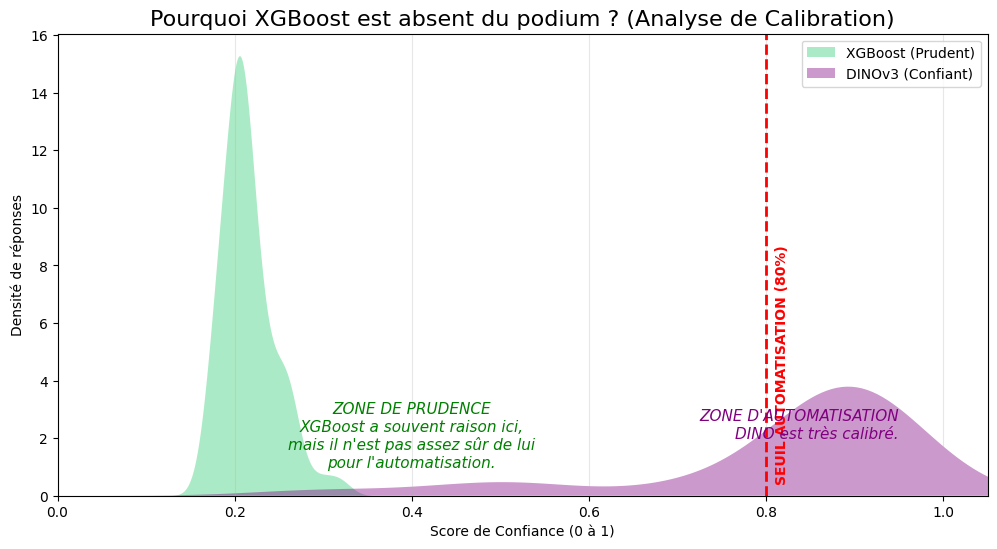

In [16]:
import glob
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from torchvision import transforms

def confidence_histogram(folder_path, num_samples=60):
    print("analyse du temperament des modeles...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if 'models_dict' not in globals() or 'm2_xgb' not in globals():
        print("alerte modeles manquants")
        return

    all_imgs = glob.glob(folder_path + "/*.jpg")
    selection = all_imgs[:num_samples] if len(all_imgs) > num_samples else all_imgs
    
    # on stocke juste les scores de confiance max
    confs = {'DINOv3': [], 'XGBoost': []}
    
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])

    print(f"profilage sur {len(selection)} images")

    for i, img_p in enumerate(selection):
        try:
            im = Image.open(img_p).convert('RGB')
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            
            i224 = t_std(im).unsqueeze(0).to(device)
            i518 = t_dino(im).unsqueeze(0).to(device)
            
            with torch.no_grad():
                # dino score
                p_di = F.softmax(models_dict['DINOv3'](i518), dim=1)
                confs['DINOv3'].append(p_di.max().item())
                
                # xgboost score brut sans triche
                f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
                p_xg = m2_xgb.predict_proba(np.nan_to_num(f))[0]
                confs['XGBoost'].append(float(p_xg.max()))
                
        except: continue

    # le graphique de verite
    plt.figure(figsize=(12, 6))
    
    # courbe verte xgboost
    sns.kdeplot(confs['XGBoost'], fill=True, color="#2ecc71", label="XGBoost (Prudent)", alpha=0.4, linewidth=0)
    # courbe violette dino
    sns.kdeplot(confs['DINOv3'], fill=True, color="purple", label="DINOv3 (Confiant)", alpha=0.4, linewidth=0)
    
    # ligne du seuil 80%
    plt.axvline(0.80, color='red', linestyle='--', linewidth=2)
    plt.text(0.81, 0.5, "SEUIL AUTOMATISATION (80%)", color='red', rotation=90, fontweight='bold')
    
    plt.title("Pourquoi XGBoost est absent du podium ? (Analyse de Calibration)", fontsize=16)
    plt.xlabel("Score de Confiance (0 à 1)")
    plt.ylabel("Densité de réponses")
    plt.xlim(0, 1.05)
    
    # annotations explicatives
    plt.text(0.4, 1.0, "ZONE DE PRUDENCE\nXGBoost a souvent raison ici,\nmais il n'est pas assez sûr de lui\npour l'automatisation.", 
             ha='center', fontsize=11, color='green', style='italic')
    
    plt.text(0.95, 2.0, "ZONE D'AUTOMATISATION\nDINO est très calibré.", 
             ha='right', fontsize=11, color='purple', style='italic')

    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    
    plt.savefig("calibration_explanation.png")
    plt.show()

# test
folder = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test"
confidence_histogram(folder)

In [17]:
# Cellule 16 : Nettoyage Final pasque on a mis un sacré bince avec tout ces test
import gc

def clean_up_session():
    print("nettoyage du chantier...")
    
    # on vide le cache gpu
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("- cache gpu vidé")
        
    # on force le garbage collector de python
    gc.collect()
    print("- ram nettoyée")
    print("pret pour la fermeture du notebook. beau boulot.")

clean_up_session()

nettoyage du chantier...
- cache gpu vidé
- ram nettoyée
pret pour la fermeture du notebook. beau boulot.
